## Libraries

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import lhapdf
from scipy.constants import physical_constants as pc
from scipy.integrate import quad
from math import pi
import math
import sympy as sy 
import numdifftools as nd
import torch as tn

## Constants

In [121]:
# Constants
s = (13e3)**2 # Center-of-mass energy squared in GeV^2
Nc = 3  # Number of colors in QCD
m_Z = 91.1876  # Mass of the Z boson in GeV/c^2
Gamma_Z = 2.4952  # Decay width of the Z boson in GeV
alpha = 1 / 137  # Fine-structure constant
sin2th_w = pc['weak mixing angle'][0]  # Mixing angle
e = 0.303 # Elementry charge in natural units


## PDF related terms

In [124]:
# Load PDF set
pdf = lhapdf.mkPDF("NNPDF31_nnlo_as_0118", 0)

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


## pdfs are generted as x*f(x,Q)

In [127]:
def f_s(x, tau_x, flavor, Q):
    return 1/x *pdf.xfxQ(flavor, x, Q) * 1/tau_x *pdf.xfxQ(-flavor, tau_x, Q) + \
           1/tau_x *pdf.xfxQ(flavor, tau_x, Q) *1/x * pdf.xfxQ(-flavor, x, Q)

def num_derivative(func, x, h=1e-15, *args):
    return (func(x + h, *args) - func(x , *args)) / (h)

def f_prime_s(x, tau_x, flavor, Q):
    f_f_tau_x_prime = num_derivative(lambda t: 1/t *pdf.xfxQ(flavor, t, Q), tau_x)
    f_fbar_tau_x_prime = num_derivative(lambda t:1/t *pdf.xfxQ(-flavor, t, Q), tau_x)
    
    return (1/x * pdf.xfxQ(flavor, x, Q) *f_fbar_tau_x_prime + \
           1/x *f_f_tau_x_prime *pdf.xfxQ(-flavor, x, Q))

In [2]:
def sigma_hat_prime(x, tau_x, C, p1, p2, flavor, Q, n):
    
    # Perform the contraction with c
    
    term1 = (n + (2 / s) * (1 + x / tau_x) *
             (tn.dot(p1, torch.mv(C, p2)) + tn.dot(p2, torch.mv(C, p1)) +
              tn.dot(p1, torch.mv(C, p1)) + tn.dot(p2, torch.mv(C, p2)))) * f_s(x, tau_x, flavor, Q)

    
    term2 = (2 / s) *(x * tn.dot(p1, torch.mv(C, p1)) + tau_x * tn.dot(p1, torch.mv(C, p2)) +
             tau_x * tn.dot(p1, torch.mv(C, p2)) + x * tn.dot(p2, torch.mv(C, p2)))* f_prime_s(x, tau_x, flavor, Q)
    
    return term1 + term2

In [131]:
def integrate_sigma_hat_prime(tau,C, p1, p2,flavor, Q, n):
    def integrand(x):
        tau_x = tau/x
        return sigma_hat_prime(x, tau, C, p1, p2, flavor, Q, n) * tau_x
    
    result, error = quad(integrand, tau, 1)
    return result

In [133]:
# Quarks
e = 0.302
quarks = [
    (2, 2/3*e, 'u', 1/2),
     #(1, -1/3*e, 'd', -1/2),
    # (3, -1/3*e, 's', -1/2),
    # (4, 2/3*e, 'c', 1/2),
    # (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2013, -0.0449, 0.4551)]


## Define terms from the equations

In [136]:
def term_1(Q2, e_f):
    return 0.389* 1e9* e_f**2 / (2*Q2**2)

In [138]:
def term_2(Q2, e_f, g, p1, p2):
    return 0.389* 1e9*(((1 - (m_Z**2 / Q2)) / ((Q2 - m_Z**2)**2 + m_Z**2 * Gamma_Z**2)) *
            (1 - 4 * sin2th_w) / (4 * sin2th_w * (1- sin2th_w ))* e_f * g)

In [140]:
def term_3(Q2, e_f, g, p1, p2):
    return 0.389* 1e9*(1 / ((Q2 - m_Z**2)**2 + m_Z**2 * Gamma_Z**2) * 
            (1 + (1 - 4 * sin2th_w)**2) / (32 * sin2th_w**2 * (1-sin2th_w)**2)) * g**2

In [142]:
def d_sigma(Q2, CL, CR, p1, p2, n):
    tau = Q2 / s
    d_sigma = 0
    d_sigmaL = 0
    d_sigmaR = 0

    for flavor, e_f, g_fR, g_fL in quark_couplings:
            integral1 = (13e3)**2 *integrate_sigma_hat_prime(tau, CL, p1, p2, flavor, np.sqrt(Q2), n)
            integral2 = (13e3)**2 *integrate_sigma_hat_prime(tau, CR, p1, p2, flavor, np.sqrt(Q2), n)
    
            d_sigmaL += 4 * np.pi * alpha**2 / (3 * Nc) * (
                        term_1(Q2, e_f) + term_2(Q2, e_f, g_fL, p1, p2) + 
                        term_3(Q2, e_f, g_fL, p1, p2)
                        ) * integral1
    
            d_sigmaR += 4 * np.pi * alpha**2 / (3 * Nc) * (
                        term_1(Q2, e_f) + term_2(Q2, e_f, g_fR, p1, p2) + 
                        term_3(Q2, e_f, g_fR, p1, p2)
                        ) * integral2
            
    
    
    return d_sigmaL+d_sigmaR, d_sigmaL, d_sigmaR

## Coefficients

In [8]:
#Don't foregt the metric convenction (+, -, -, -)

CL = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 2e-5]
], dtype=tn.float32)

CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

## SM Case

In [148]:
# Q_val3 = np.linspace(17.5, 90, 100)

# sm = [d_sigma(Q**2, 0, 0, p1, p2, 1) for Q in Q_val3]
# dsigma_sm, dsigmaL_sm, dsigmaR_sm = zip(*sm)

# plt.figure(figsize=(20, 6))
# Q2_val3 = Q_val3**2
# # Create plot
# plt.plot(Q2_val3, dsigma_sm ,color='r', linestyle='-')

# plt.xlabel('$Q^2$')
# plt.yscale('log')
# plt.ylabel('$d\\sigma /dQ^2$')
# plt.title(f'$d\\sigma/dQ^2$ vs $Q^2$ in case of SM, $C^{{33}}_{{uL}}=${0} and $C^{{33}}_{{uR}}=${0}')
# plt.savefig('intrsec.png')
# plt.show()

## Calculations for the UP Quark

In [160]:
# Integration and plotting
Q_val = np.linspace(17.5, 90, 100)
a = 17.5 # Start of the Q range
b = 90  # End of the Q range
nbins = 17  # Number of bins
# Example momenta for protons
p1 = 1 / np.sqrt(2) * tn.tensor([1,0, 0,1], dtype=torch.float32)

p1 = 1 / np.sqrt(2) * tn.tensor([1,0, 0,-1], dtype=torch.float32)


Q_bins = np.linspace(a, b, nbins + 1)
integrated_values = []

# Integrate d_sigma over each bin
results = [d_sigma(Q**2, CL, CR, p1, p2, 0) for Q in Q_val]
dsigma, dsigmaL, dsigmaR = zip(*results)

def integrand(Q, CL, CR, p1, p2, n):
    return d_sigma(Q**2,CL, CR, p1, p2, 0)[0]
    
for i in range(len(Q_bins) - 1):
    Q_start = Q_bins[i]
    Q_end = Q_bins[i + 1]
    integral, _ = quad(integrand , Q_start, Q_end, args=(CL, CR, p1, p2, 0))
    integrated_values.append(integral)

/tmp/ipykernel_87748/1049043246.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand , Q_start, Q_end, args=(CL, CR, p1, p2, 0))
/tmp/ipykernel_87748/1049043246.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand , Q_start, Q_end, args=(CL, CR, p1, p2, 0))


## Up quark cross section plot

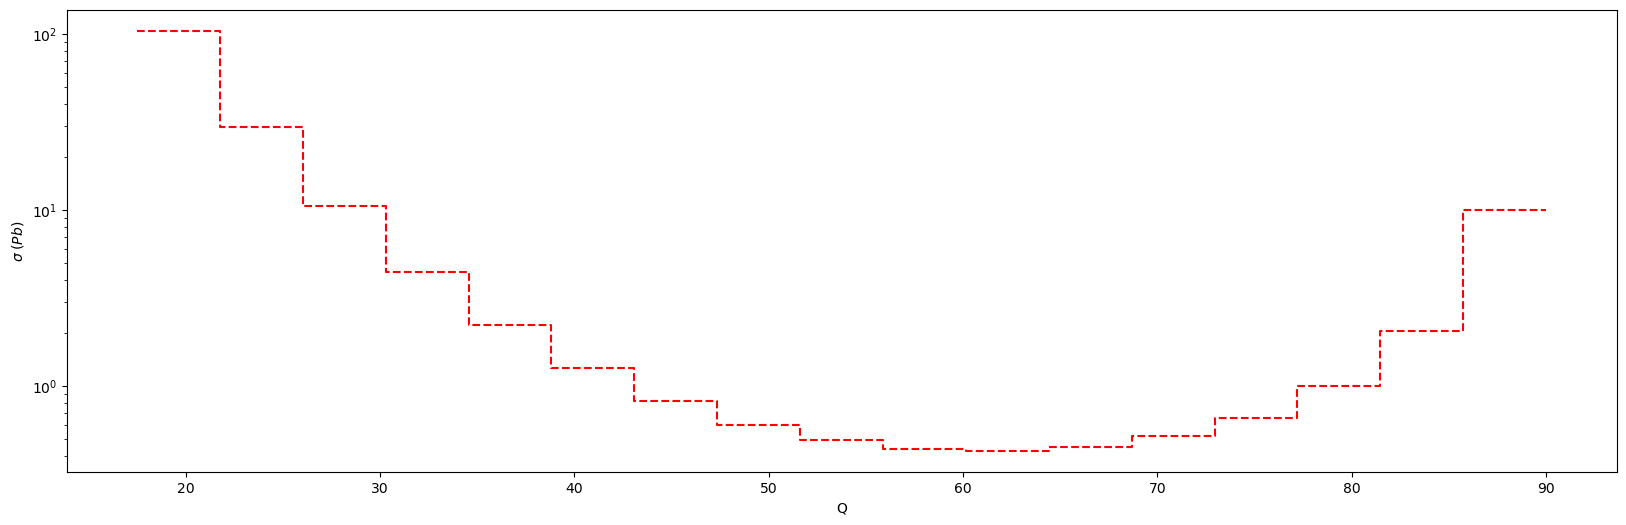

In [161]:
plt.figure(figsize=(20, 6))

# Create the step plot
plt.step(Q_bins, integrated_values + [integrated_values[-1]], where='post', color='r', linestyle='--')

plt.xlabel('Q')
plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.savefig('intrsec.png')
plt.show()

## PLOTS

## Individual terms behaviour

In [ ]:
Q_val = np.linspace(17.5, 90, 100)

terms = {f"term{i}": [] for i in range(1, 6)}
sum1 = []
sum2 = []

# Define axs for subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# 
for flavour, e_f, g_fR, g_fL in quark_couplings:
    results = [d_sigma(Q**2, c_33L, c_33R, p1, p2, 0) for Q in Q_val]
    dsigma, dsigmaL, dsigmaR = zip(*results)
    
    term1 = [term_1(Q**2, e_f) for Q in Q_val]
    term2 = [term_2(Q**2, e_f, g_fL, p1, p2) for Q in Q_val]
    term3 = [term_3(Q**2, e_f, g_fL, p1, p2) for Q in Q_val] 
    term4 = [term_2(Q**2, e_f, g_fR, p1, p2) for Q in Q_val]
    term5 = [term_3(Q**2, e_f, g_fR, p1, p2) for Q in Q_val]
    
    
    terms['term1'].append(term1)
    terms['term2'].append(term2)
    terms['term3'].append(term3)
    terms['term4'].append(term4)
    terms['term5'].append(term5)

# Plot sum 1 and sum 2 in the first subplot
axs[0].plot(Q_val, dsigmaL, linestyle='-', color='y', label='$d\\sigma L$')
axs[0].plot(Q_val, dsigmaR, linestyle='-', color='black', label='$d\\sigma R$')
axs[0].plot(Q_val, dsigma, linestyle='-', color='red', label='$d \\sigma$')

axs[0].set_yscale('log')
axs[0].set_title('$d\\sigma$')
axs[0].set_xlabel('Q')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# Plot terms 1 to 5 in the second subplot
axs[1].plot(Q_val, terms['term1'][0], linestyle='-', color='b', label='term 1')
axs[1].plot(Q_val, terms['term2'][0], linestyle='-', color='g', label='term 2L')
axs[1].plot(Q_val, terms['term3'][0], linestyle='-', color='m', label='term 3L')
axs[1].plot(Q_val, terms['term4'][0], linestyle='-', color='y', label='term 2R')
axs[1].plot(Q_val, terms['term5'][0], linestyle='-', color='r', label='term 3R')
axs[1].set_yscale('log')
axs[1].set_title('Terms 1 to 5')
axs[1].set_xlabel('Q')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## PDFs behaviour

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined your functions f_s(x, tau_x, flavor, Qe) and f_prime_s(x, tau_x, flavor, Qe)

x_val1 = np.logspace(-3, np.log10(0.9), 100)
Qe = 60

tau = Qe**2 / s
tau_x_val1 = tau / x_val1

x = 1e-3

# Calculate fs and fprime_s values

fs_valx = [f_s(x, tau / x, flavor, Qe) for x in x_val1]
fprime_s_valx = [f_prime_s(x, tau / x, flavor, Qe) for x in x_val1]

fs_val_taux = [f_s(x, tau_x, flavor, Qe) for tau_x in tau_x_val1]
fprime_s_val_taux = [f_prime_s(x, tau_x, flavor, Qe) for tau_x in tau_x_val1]

# PDF Plotting

fig, axs = plt.subplots(2, 2, figsize=(20, 8))
axs = axs.flatten()  # Flatten the array of axes

axs[0].plot(x_val1, fs_valx, label='$f_s$')

axs[0].set_yscale('linear')
axs[0].set_title(f'Plot of $f_s(x)$ vs $x$ at $Q = {Qe}$ GeV')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(tau_x_val1, fs_val_taux, label='$f_s$')

axs[1].set_xscale('log')
axs[1].set_yscale('linear')
axs[1].set_title(f'Plot of $f_s(\\tau / x)$ vs $\\tau / x$ at $Q = {Qe}$ GeV')
axs[1].set_xlabel('$\\tau / x$')
axs[1].set_ylabel('')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(x_val1, fprime_s_valx, label='$f\'_s$')

axs[2].set_yscale('linear')
axs[2].set_title(f'Plot of $f\'_s(x)$ vs $x$ at $Q = {Qe}$ GeV')
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(tau_x_val1, fprime_s_val_taux, label='$f\'_s$')

axs[3].set_xscale('log')
axs[3].set_yscale('linear')
axs[3].set_title(f'Plot of $f\'_s(\\tau / x)$ vs $\\tau / x$ at $Q = {Qe}$ GeV')
axs[3].set_xlabel('$\\tau / x$')
axs[3].set_ylabel('')
axs[3].legend()
axs[3].grid(True)

fig.suptitle('Flavour-symmetric PDF products')

plt.tight_layout()

plt.savefig('pdf.png')
plt.show()


In [ ]:
x_val = np.logspace(-3, np.log10(0.9), 100)
Qp = 60
tau = Qp**2 / s

tau_x_val = tau /x_val

# Define axs for subplot
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Calculate terms and sums
for quark in quark_couplings:
    flavor = quark[0]
    pdf_val = [pdf.xfxQ(flavor, x, Qp) for x in x_val]
    pdf_val_tau_x = [pdf.xfxQ(-flavor, tau_x, Qp) for tau_x in tau_x_val]
    f_f_tau_x_prime = [num_derivative(lambda t: pdf.xfxQ(flavor, t, Qp), tau_x) for tau_x in tau_x_val]    
# Plot 
axs[0].plot(x_val, pdf_val, linestyle='-', color='indigo', label='$f(x)$')


axs[0].set_xscale('log')
axs[0].set_title(f'PDF at Q = {Qp} GeV')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# Plot
axs[1].plot(tau_x_val, pdf_val_tau_x, linestyle='-', color='indigo', label='$f(\\tau/x)$')
axs[1].set_xscale('log')
axs[1].set_title(f'PDF at Q = {Qp} GeV')
axs[1].set_xlabel('${\\tau} /x$')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

# Plot 
axs[2].plot(tau_x_val, f_f_tau_x_prime, linestyle='-', color='indigo', label='$f\'(\\tau /x)$')
axs[2].set_xscale('log')
axs[2].set_title(f'PDF derivative at Q = {Qp} GeV')
axs[2].set_xlabel('$\\tau /x$')
axs[2].set_ylabel('Value')
axs[2].legend()
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
import torch

# Example tensors
C = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
p = torch.tensor([5, 0], dtype=torch.float32)

# Tensor contraction
result = torch.dot(C, p)

print(result)


RuntimeError: 1D tensors expected, but got 2D and 1D tensors

In [16]:
?tn.dot

Docstring:
dot(input, other, *, out=None) -> Tensor

Computes the dot product of two 1D tensors.

.. note::

    Unlike NumPy's dot, torch.dot intentionally only supports computing the dot product
    of two 1D tensors with the same number of elements.

Args:
    input (Tensor): first tensor in the dot product, must be 1D.
    other (Tensor): second tensor in the dot product, must be 1D.

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> torch.dot(torch.tensor([2, 3]), torch.tensor([2, 1]))
    tensor(7)
Type:      builtin_function_or_method

In [22]:
print(torch.dot(torch.tensor([0, 3]), torch.tensor([0, 1])))

tensor(3)


In [56]:
import torch

# Example tensors
C = torch.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

p1 = np.sqrt(2)*torch.tensor([1, ,3,1], dtype=torch.float32)
p2 = torch.tensor([1,2,1,-1], dtype=torch.float32)

# Tensor contraction: p1_mu * C^{mu nu} * p2_nu
result = torch.dot(p1, torch.mv(C, p2))

print(result)


tensor(7.0711)


## Rotation Matrices

In [25]:
alpha = 0.705
R_x = tn.tensor([[1,0,0,0],
                 [0,1,0,0],
                 [0,0,np.cos(alpha),-np.sin(alpha)],
                 [0,0,np.sin(alpha), np.cos(alpha)]],
                dtype=tn.float32)

In [27]:
print(R_x)

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.7616, -0.6480],
        [ 0.0000,  0.0000,  0.6480,  0.7616]])
